# FomulaBEAT

変更点
- 9999までの数の偶数奇数を判定するタスク


In [1]:
version = '03-2'
model_dir = './model/' + version
data_path = 'data/eq04-2.txt'

In [2]:
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import torch.nn.functional as F


/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchte

パラメータの事前設定

In [3]:
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

データの取得

In [5]:
def read_equation_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [6]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_equation_file(data_path)
print(src_data[:3], tgt_data[:3])


['8912', '8624', '1989'] ['0', '0', '1']


辞書データの作成

In [7]:

SPECIALS = ['<unk>', '<pad>', '<start>', '<end>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [8]:
# 辞書と逆辞書を構築
vocab_src = build_vocab(src_data)
vocab_tgt = build_vocab(tgt_data)

print(vocab_tgt)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '<unk>': 10, '<pad>': 11, '<start>': 12, '<end>': 13}


In [9]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0].tolist(), vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1].tolist(), vocab_tgt)}")


インデックス化された文章
Input: tensor([12,  1,  1,  3,  2, 13])
Output: tensor([12,  0, 13])
元に戻した文章
Input: 1132
Output: 0


In [10]:
batch_size = 32
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [11]:
len(train_data)

8000

Transoformerの設定

In [12]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [13]:

class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Feedforward layers
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Attention with the encoder outputs (memory)
        tgt2, _ = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        # Feedforward network
        tgt2 = self.linear2(self.dropout(F.relu(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)

        return tgt


In [14]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size_src: int, vocab_size_tgt: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding_src = TokenEmbedding(vocab_size_src, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        
        self.token_embedding_tgt = TokenEmbedding(vocab_size_tgt, embedding_size)
        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        self.output = nn.Linear(embedding_size, vocab_size_tgt)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding_src(src))
        # memory = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding_tgt(tgt))
        outs = self.decoder_layer(
            embedding_tgt, embedding_src, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.output(outs)

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding_tgt(tgt)), memory, mask_tgt)

In [15]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [16]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [17]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [18]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 4
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size_src=vocab_size_src, vocab_size_tgt=vocab_size_tgt,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [19]:
print(model)

Seq2SeqTransformer(
  (token_embedding_src): TokenEmbedding(
    (embedding): Embedding(14, 4, padding_idx=11)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (token_embedding_tgt): TokenEmbedding(
    (embedding): Embedding(14, 4, padding_idx=11)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (linear1): Linear(in_features=4, out_features=4, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (linear2): Linear(in_features=4, out_features=4, bias=True)
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (d

In [20]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


22 層

層名: token_embedding_src.embedding.weight
形状: torch.Size([14, 4])
値: Parameter containing:
tensor([[-0.4778,  0.4437,  0.0729, -0.3144],
        [-0.3680, -0.3223,  0.3245, -0.4697],
        [-0.3704,  0.4004, -0.0625,  0.2812],
        [ 0.1092, -0.3720,  0.3995,  0.3195],
        [ 0.3788,  0.3370, -0.3922,  0.3573],
        [ 0.3632, -0.1276,  0.1895, -0.4051],
        [-0.4899, -0.0126,  0.0549, -0.1896],
        [-0.0873,  0.4317,  0.0599, -0.0532],
        [ 0.1549,  0.0291,  0.2037, -0.5142],
        [ 0.1941, -0.0571, -0.3433,  0.3246],
        [ 0.1879, -0.3275, -0.5599,  0.3604],
        [ 0.5266,  0.5336, -0.3793,  0.5770],
        [-0.2239,  0.5754,  0.2563, -0.2578],
        [ 0.3355, -0.4787,  0.0714,  0.1588]], device='cuda:0', requires_grad=True)

層名: token_embedding_tgt.embedding.weight
形状: torch.Size([14, 4])
値: Parameter containing:
tensor([[ 0.0627, -0.3396,  0.4361, -0.1480],
        [-0.4034, -0.5268, -0.1490, -0.4644],
        [-0.0035,  0.5064, -0.3769,  0.

## 学習実行

In [21]:
epoch = 100
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    
    counter += 1

  0%|          | 0/250 [00:00<?, ?it/s]/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 250/250 [00:02<00:00, 85.86it/s]


[1/100] train loss: 1.18, valid loss: 0.64  [3s] counter: 0 **


100%|██████████| 250/250 [00:02<00:00, 90.91it/s]


[2/100] train loss: 0.47, valid loss: 0.30  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 90.63it/s]


[3/100] train loss: 0.18, valid loss: 0.11  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 91.00it/s]


[4/100] train loss: 0.09, valid loss: 0.06  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 91.22it/s]


[5/100] train loss: 0.05, valid loss: 0.04  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 91.09it/s]


[6/100] train loss: 0.03, valid loss: 0.03  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 91.15it/s]


[7/100] train loss: 0.02, valid loss: 0.01  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 94.62it/s] 


[8/100] train loss: 0.01, valid loss: 0.01  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 94.34it/s]


[9/100] train loss: 0.01, valid loss: 0.01  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 91.01it/s]


[10/100] train loss: 0.01, valid loss: 0.01  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 91.25it/s]


[11/100] train loss: 0.01, valid loss: 0.01  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 91.18it/s]


[12/100] train loss: 0.01, valid loss: 0.01  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 91.17it/s]


[13/100] train loss: 0.01, valid loss: 0.00  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 91.17it/s]


[14/100] train loss: 0.00, valid loss: 0.00  [3s] counter: 1 **


100%|██████████| 250/250 [00:02<00:00, 91.11it/s]


[15/100] train loss: 0.00, valid loss: 0.01  [3s] counter: 1 


100%|██████████| 250/250 [00:02<00:00, 91.08it/s]


[16/100] train loss: 0.00, valid loss: 0.00  [3s] counter: 2 


100%|██████████| 250/250 [00:02<00:00, 91.37it/s]


[17/100] train loss: 0.00, valid loss: 0.00  [3s] counter: 3 **


100%|██████████| 250/250 [00:02<00:00, 91.01it/s]


[18/100] train loss: 0.00, valid loss: 0.00  [3s] counter: 1 


100%|██████████| 250/250 [00:01<00:00, 136.39it/s]


[19/100] train loss: 0.00, valid loss: 0.00  [2s] counter: 2 **


100%|██████████| 250/250 [00:00<00:00, 264.63it/s]


[20/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 250/250 [00:00<00:00, 264.48it/s]


[21/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 2 **


100%|██████████| 250/250 [00:00<00:00, 263.01it/s]


[22/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 250/250 [00:00<00:00, 263.25it/s]


[23/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 2 **


100%|██████████| 250/250 [00:00<00:00, 265.22it/s]


[24/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 250/250 [00:00<00:00, 264.30it/s]


[25/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 2 **


100%|██████████| 250/250 [00:00<00:00, 264.81it/s]


[26/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 250/250 [00:00<00:00, 262.51it/s]


[27/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 250/250 [00:00<00:00, 262.99it/s]


[28/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 2 


100%|██████████| 250/250 [00:00<00:00, 264.03it/s]


[29/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 3 **


100%|██████████| 250/250 [00:00<00:00, 265.37it/s]


[30/100] train loss: 0.00, valid loss: 0.01  [1s] counter: 1 


100%|██████████| 250/250 [00:00<00:00, 264.25it/s]


[31/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 2 


100%|██████████| 250/250 [00:00<00:00, 264.05it/s]


[32/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 3 **


100%|██████████| 250/250 [00:00<00:00, 263.56it/s]


[33/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 250/250 [00:00<00:00, 264.19it/s]


[34/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 2 **


100%|██████████| 250/250 [00:00<00:00, 264.39it/s]


[35/100] train loss: 0.00, valid loss: 0.01  [1s] counter: 1 


100%|██████████| 250/250 [00:00<00:00, 262.99it/s]


[36/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 2 **


100%|██████████| 250/250 [00:00<00:00, 262.87it/s]


[37/100] train loss: 0.01, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 250/250 [00:00<00:00, 264.85it/s]


[38/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 2 


100%|██████████| 250/250 [00:00<00:00, 263.09it/s]


[39/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 3 


100%|██████████| 250/250 [00:00<00:00, 264.17it/s]


[40/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 4 


100%|██████████| 250/250 [00:00<00:00, 262.68it/s]


[41/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 5 


100%|██████████| 250/250 [00:00<00:00, 263.21it/s]


[42/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 6 **


100%|██████████| 250/250 [00:00<00:00, 264.00it/s]


[43/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 250/250 [00:00<00:00, 265.12it/s]


[44/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 2 **


100%|██████████| 250/250 [00:00<00:00, 263.99it/s]


[45/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 250/250 [00:00<00:00, 264.57it/s]


[46/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 250/250 [00:00<00:00, 263.97it/s]


[47/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 2 


100%|██████████| 250/250 [00:00<00:00, 264.65it/s]


[48/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 3 


100%|██████████| 250/250 [00:00<00:00, 264.04it/s]


[49/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 4 **


100%|██████████| 250/250 [00:00<00:00, 263.18it/s]


[50/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 250/250 [00:00<00:00, 262.90it/s]


[51/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 2 


100%|██████████| 250/250 [00:00<00:00, 264.52it/s]


[52/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 3 


100%|██████████| 250/250 [00:00<00:00, 264.41it/s]


[53/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 4 **


100%|██████████| 250/250 [00:00<00:00, 264.62it/s]


[54/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 250/250 [00:00<00:00, 262.61it/s]


[55/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 250/250 [00:00<00:00, 264.70it/s]


[56/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 250/250 [00:00<00:00, 264.19it/s]


[57/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 250/250 [00:00<00:00, 264.69it/s]


[58/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 250/250 [00:00<00:00, 264.37it/s]


[59/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 250/250 [00:00<00:00, 263.27it/s]


[60/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 250/250 [00:00<00:00, 264.11it/s]


[61/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 250/250 [00:00<00:00, 264.47it/s]


[62/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 250/250 [00:00<00:00, 264.11it/s]


[63/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 250/250 [00:00<00:00, 262.88it/s]


[64/100] train loss: 0.01, valid loss: 0.00  [1s] counter: 2 


100%|██████████| 250/250 [00:00<00:00, 263.37it/s]


[65/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 3 


100%|██████████| 250/250 [00:00<00:00, 264.12it/s]


[66/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 4 


100%|██████████| 250/250 [00:00<00:00, 263.86it/s]


[67/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 5 


100%|██████████| 250/250 [00:00<00:00, 263.59it/s]


[68/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 6 


100%|██████████| 250/250 [00:00<00:00, 263.90it/s]


[69/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 7 


100%|██████████| 250/250 [00:02<00:00, 104.77it/s]


[70/100] train loss: 0.00, valid loss: 0.00  [2s] counter: 8 


100%|██████████| 250/250 [00:02<00:00, 91.13it/s]


[71/100] train loss: 0.00, valid loss: 0.00  [3s] counter: 9 


100%|██████████| 250/250 [00:02<00:00, 91.38it/s]


[72/100] train loss: 0.00, valid loss: 0.00  [3s] counter: 10 


100%|██████████| 250/250 [00:02<00:00, 91.37it/s]


[73/100] train loss: 0.00, valid loss: 0.00  [3s] counter: 11 


学習したモデルの保存

In [22]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [23]:
def translate(
    model, text, vocab_src, vocab_tgt, seq_len_tgt,
    START_IDX, END_IDX
):
    model.eval()
    tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
    num_tokens_src = len(tokens_src)

    # Tensorに変換
    src = torch.LongTensor(tokens_src).reshape(num_tokens_src, 1).to(device)
    mask_src = torch.zeros((num_tokens_src, num_tokens_src), device=device).type(torch.bool)

    # デコード
    predicts = greedy_decode(
        model=model, src=src,
        mask_src=mask_src, seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    ).flatten()

    return convert_indexes_to_text(predicts.tolist(), vocab=vocab_tgt)

def greedy_decode(model, src, mask_src, seq_len_tgt, START_IDX, END_IDX):
    src = src.to(device)
    mask_src = mask_src.to(device)

    # ソースの埋め込みをメモリとして利用
    memory = model.positional_encoding(model.token_embedding_src(src))
    
    ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
    
    for i in range(seq_len_tgt - 1):
        memory = memory.to(device)
        mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)
        
        output = model.decode(ys, memory, mask_tgt)
        output = output.transpose(0, 1)
        output = model.output(output[:, -1])
        
        # 最も高いスコアのトークンを取得
        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        # 生成されたトークンを追加
        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
        if next_word == END_IDX:
            break
    
    return ys


In [50]:
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '20'

# 翻訳を実行
translation = translate(
    model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

print(f"Input: {text}")
print(f"Output: {translation}")

Input: 20
Output: 0


In [63]:
# 様々な入力を試してみる

text_list = ["1", "2", "3", "11", "5009", "200", "9999", "200033", "200004448", "20000006699"]

for text in text_list:
    translation = translate(
        model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
        seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    )
    print(f"Input: {text}")
    print(f"Output: {translation}")




Input: 1
Output: 1
Input: 2
Output: 0
Input: 3
Output: 1
Input: 11
Output: 1
Input: 5009
Output: 1
Input: 200
Output: 0
Input: 9999
Output: 1
Input: 200033
Output: 0
Input: 200004448
Output: 0
Input: 20000006699
Output: 0


In [64]:
# 網羅性チェック
# 0-99999までの数値の偶数奇数を判断して、ミスがないか確認

count = 0
for text in range(0, 20000):
    translation = translate(
        model=best_model, text=str(text), vocab_src=vocab_src, vocab_tgt=vocab_tgt,
        seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    )
    # 偶数かつ奇数として判断された場合のみ表示
    if text % 2 == 0 and translation == '1':
        print(f"in/tl: {text}/{translation}")
        count += 1
    elif text % 2 == 1 and translation == '0':
        print(f"in/tl: {text}/{translation}")
        count += 1

# 10000を超えると、翻訳が正しく行われない
print(count)

in/tl: 10001/0
in/tl: 10003/0
in/tl: 10005/0
in/tl: 10007/0
in/tl: 10009/0
in/tl: 10021/0
in/tl: 10023/0
in/tl: 10025/0
in/tl: 10027/0
in/tl: 10029/0
in/tl: 10041/0
in/tl: 10043/0
in/tl: 10045/0
in/tl: 10047/0
in/tl: 10049/0
in/tl: 10061/0
in/tl: 10063/0
in/tl: 10065/0
in/tl: 10067/0
in/tl: 10069/0
in/tl: 10081/0
in/tl: 10083/0
in/tl: 10085/0
in/tl: 10087/0
in/tl: 10089/0
in/tl: 10101/0
in/tl: 10103/0
in/tl: 10105/0
in/tl: 10107/0
in/tl: 10109/0
in/tl: 10121/0
in/tl: 10123/0
in/tl: 10125/0
in/tl: 10127/0
in/tl: 10129/0
in/tl: 10141/0
in/tl: 10143/0
in/tl: 10145/0
in/tl: 10147/0
in/tl: 10149/0
in/tl: 10161/0
in/tl: 10163/0
in/tl: 10165/0
in/tl: 10167/0
in/tl: 10169/0
in/tl: 10181/0
in/tl: 10183/0
in/tl: 10185/0
in/tl: 10187/0
in/tl: 10189/0
in/tl: 10201/0
in/tl: 10203/0
in/tl: 10205/0
in/tl: 10207/0
in/tl: 10209/0
in/tl: 10221/0
in/tl: 10223/0
in/tl: 10225/0
in/tl: 10227/0
in/tl: 10229/0
in/tl: 10241/0
in/tl: 10243/0
in/tl: 10245/0
in/tl: 10247/0
in/tl: 10249/0
in/tl: 10261/0
in/tl: 102

In [65]:
# 網羅性チェック
# 0-99999までの数値の偶数奇数を判断して、ミスがないか確認

count = 0
for text in range(10000, 20000):
    translation = translate(
        model=best_model, text=str(text), vocab_src=vocab_src, vocab_tgt=vocab_tgt,
        seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    )
    # 偶数かつ奇数として判断された場合のみ表示
    if text % 2 == 0 and translation == '1':
        print(f"in/tl: {text}/{translation}")
        count += 1
    elif text % 2 == 1 and translation == '0':
        print(f"in/tl: {text}/{translation}")
        count += 1

# 10000を超えると、翻訳が正しく行われない
print(count)

in/tl: 10001/0
in/tl: 10003/0
in/tl: 10005/0
in/tl: 10007/0
in/tl: 10009/0
in/tl: 10021/0
in/tl: 10023/0
in/tl: 10025/0
in/tl: 10027/0
in/tl: 10029/0
in/tl: 10041/0
in/tl: 10043/0
in/tl: 10045/0
in/tl: 10047/0
in/tl: 10049/0
in/tl: 10061/0
in/tl: 10063/0
in/tl: 10065/0
in/tl: 10067/0
in/tl: 10069/0
in/tl: 10081/0
in/tl: 10083/0
in/tl: 10085/0
in/tl: 10087/0
in/tl: 10089/0
in/tl: 10101/0
in/tl: 10103/0
in/tl: 10105/0
in/tl: 10107/0
in/tl: 10109/0
in/tl: 10121/0
in/tl: 10123/0
in/tl: 10125/0
in/tl: 10127/0
in/tl: 10129/0
in/tl: 10141/0
in/tl: 10143/0
in/tl: 10145/0
in/tl: 10147/0
in/tl: 10149/0
in/tl: 10161/0
in/tl: 10163/0
in/tl: 10165/0
in/tl: 10167/0
in/tl: 10169/0
in/tl: 10181/0
in/tl: 10183/0
in/tl: 10185/0
in/tl: 10187/0
in/tl: 10189/0
in/tl: 10201/0
in/tl: 10203/0
in/tl: 10205/0
in/tl: 10207/0
in/tl: 10209/0
in/tl: 10221/0
in/tl: 10223/0
in/tl: 10225/0
in/tl: 10227/0
in/tl: 10229/0
in/tl: 10241/0
in/tl: 10243/0
in/tl: 10245/0
in/tl: 10247/0
in/tl: 10249/0
in/tl: 10261/0
in/tl: 102

## モデルの動作を分析

In [21]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size_src=vocab_size_src, vocab_size_tgt=vocab_size_tgt,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqTransformer(
  (token_embedding_src): TokenEmbedding(
    (embedding): Embedding(14, 4, padding_idx=11)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (token_embedding_tgt): TokenEmbedding(
    (embedding): Embedding(14, 4, padding_idx=11)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (linear1): Linear(in_features=4, out_features=4, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (linear2): Linear(in_features=4, out_features=4, bias=True)
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (d

In [28]:

# モデルのパラメータを確認
params = dict(loaded_model.named_parameters())

for k, v in params.items():
    print(k, v.shape)



token_embedding_src.embedding.weight torch.Size([14, 4])
token_embedding_tgt.embedding.weight torch.Size([14, 4])
decoder_layer.self_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.self_attn.in_proj_bias torch.Size([12])
decoder_layer.self_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.self_attn.out_proj.bias torch.Size([4])
decoder_layer.multihead_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.multihead_attn.in_proj_bias torch.Size([12])
decoder_layer.multihead_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.multihead_attn.out_proj.bias torch.Size([4])
decoder_layer.linear1.weight torch.Size([4, 4])
decoder_layer.linear1.bias torch.Size([4])
decoder_layer.linear2.weight torch.Size([4, 4])
decoder_layer.linear2.bias torch.Size([4])
decoder_layer.norm1.weight torch.Size([4])
decoder_layer.norm1.bias torch.Size([4])
decoder_layer.norm2.weight torch.Size([4])
decoder_layer.norm2.bias torch.Size([4])
decoder_layer.norm3.weight torch.Size([4])
decoder_layer.norm3.b

In [ ]:

# パラメータを取り出す

# 埋め込み行列を取得
embedding_src_weight = params['token_embedding_src.embedding.weight'].data
embedding_tgt_weight = params['token_embedding_tgt.embedding.weight'].data

# 線形層の重みとバイアス
output_weight = params['output.weight'].data
output_bias = params['output.bias'].data

# デコーダの自己注意の重みとバイアス
self_attn_in_proj_weight = params['decoder_layer.self_attn.in_proj_weight'].data
self_attn_in_proj_bias = params['decoder_layer.self_attn.in_proj_bias'].data
self_attn_out_proj_weight = params['decoder_layer.self_attn.out_proj.weight'].data
self_attn_out_proj_bias = params['decoder_layer.self_attn.out_proj.bias'].data

# メモリー注意の重みとバイアス
multihead_attn_in_proj_weight = params['decoder_layer.multihead_attn.in_proj_weight'].data
multihead_attn_in_proj_bias = params['decoder_layer.multihead_attn.in_proj_bias'].data
multihead_attn_out_proj_weight = params['decoder_layer.multihead_attn.out_proj.weight'].data
multihead_attn_out_proj_bias = params['decoder_layer.multihead_attn.out_proj.bias'].data

# フィードフォワードネットワークの重みとバイアス
linear1_weight = params['decoder_layer.linear1.weight'].data
linear1_bias = params['decoder_layer.linear1.bias'].data
linear2_weight = params['decoder_layer.linear2.weight'].data
linear2_bias = params['decoder_layer.linear2.bias'].data

# LayerNormのパラメータ
norm1_weight = params['decoder_layer.norm1.weight'].data
norm1_bias = params['decoder_layer.norm1.bias'].data
norm2_weight = params['decoder_layer.norm2.weight'].data
norm2_bias = params['decoder_layer.norm2.bias'].data
norm3_weight = params['decoder_layer.norm3.weight'].data
norm3_bias = params['decoder_layer.norm3.bias'].data


In [23]:

# Positional Encoding
def positional_encoding(tensor: Tensor, maxlen=5000):
    embedding_size = tensor.size(-1)
    den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    embedding_pos = torch.zeros((maxlen, embedding_size))
    embedding_pos[:, 0::2] = torch.sin(pos * den)
    embedding_pos[:, 1::2] = torch.cos(pos * den)
    embedding_pos = embedding_pos.unsqueeze(-2)
    return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
# ヒートマップを描画する関数
def visualize_attention(attn_weights, src_tokens, tgt_tokens, title="Attention Weights"):
    """
    attn_weights: Attention weights (2D numpy array)
    src_tokens: Source tokens (list of token strings)
    tgt_tokens: Target tokens (list of token strings)
    title: Title of the plot
    """
    plt.figure(figsize=(5, 5))
    sns.heatmap(attn_weights, cmap="viridis", xticklabels=src_tokens, yticklabels=tgt_tokens)
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.title(title)
    plt.show()


# インデックスからlistに戻す
def convert_indexes_to_list(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return [reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx]]


def visualize_scatter(points, title="Scatter Plot"):
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1])
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(title)
    plt.show()

## Embeddingを見る

tensor([[-0.2459, -0.3462],
        [ 0.2268,  0.4715],
        [-0.2492,  0.0787],
        [ 0.3967,  0.6070],
        [-0.0121,  0.3887],
        [ 0.4434,  1.0117],
        [-0.5530, -0.1583],
        [ 0.0951,  0.1892],
        [-0.3655,  0.0172],
        [ 0.2834,  0.3894],
        [ 0.1483, -0.1588],
        [ 0.4688, -0.4443],
        [-0.0815,  0.5221],
        [ 0.8289, -0.2398]])


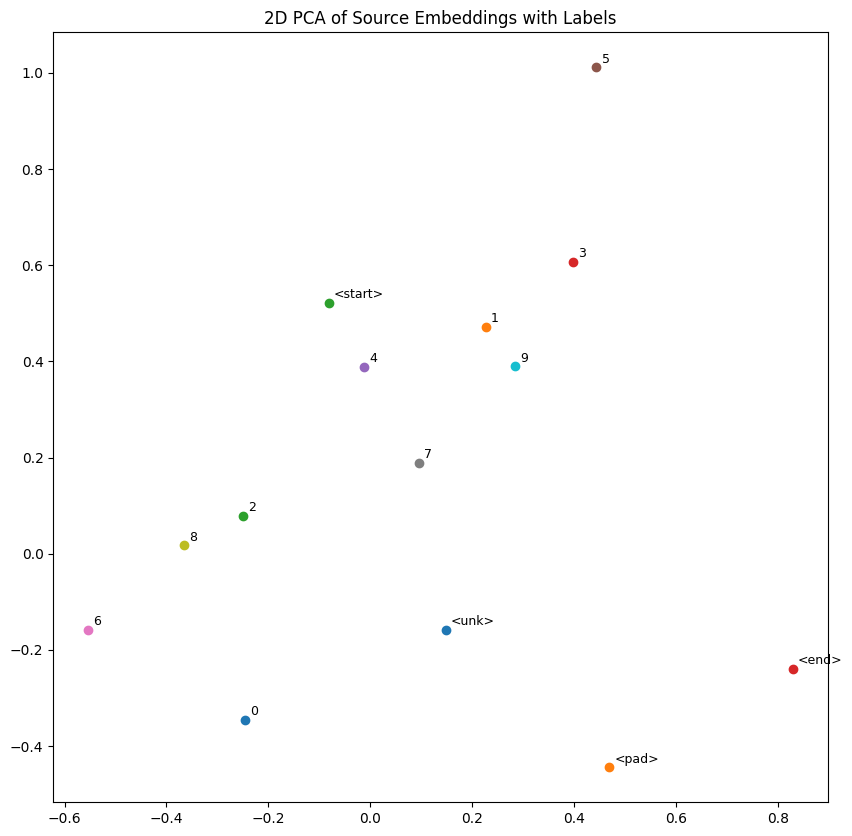

In [88]:
embedding_src_cpu = embedding_src_weight.cpu().detach()
print(embedding_src_cpu[: , :2])

# 逆辞書を作成してインデックスを文字に変換
reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}

# 可視化
plt.figure(figsize=(10, 10))

# 各ポイントを散布図でプロットし、対応するラベルを表示
for i, (x, y) in enumerate(embedding_src_cpu[:, :2]):  # [:, :2]をスライスし、次にenumerate
    label = reverse_vocab_src[i]  # インデックスを元のトークンに戻す
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)  # 各点の近くにラベルを表示

plt.title("2D PCA of Source Embeddings with Labels")
plt.show()

tensor([[-0.0654, -0.2982],
        [ 0.3928,  0.7616],
        [-0.3449, -0.5731],
        [-0.4126,  0.3292],
        [ 0.4813,  0.2821],
        [ 0.4080, -0.0379],
        [ 0.5595, -0.5041],
        [ 0.3590,  0.4244],
        [-0.0226, -0.4489],
        [ 0.0693, -0.2612],
        [ 0.2897, -0.5343],
        [-0.3838, -0.2568],
        [-0.4932,  0.4038],
        [-0.1535, -0.3741]])


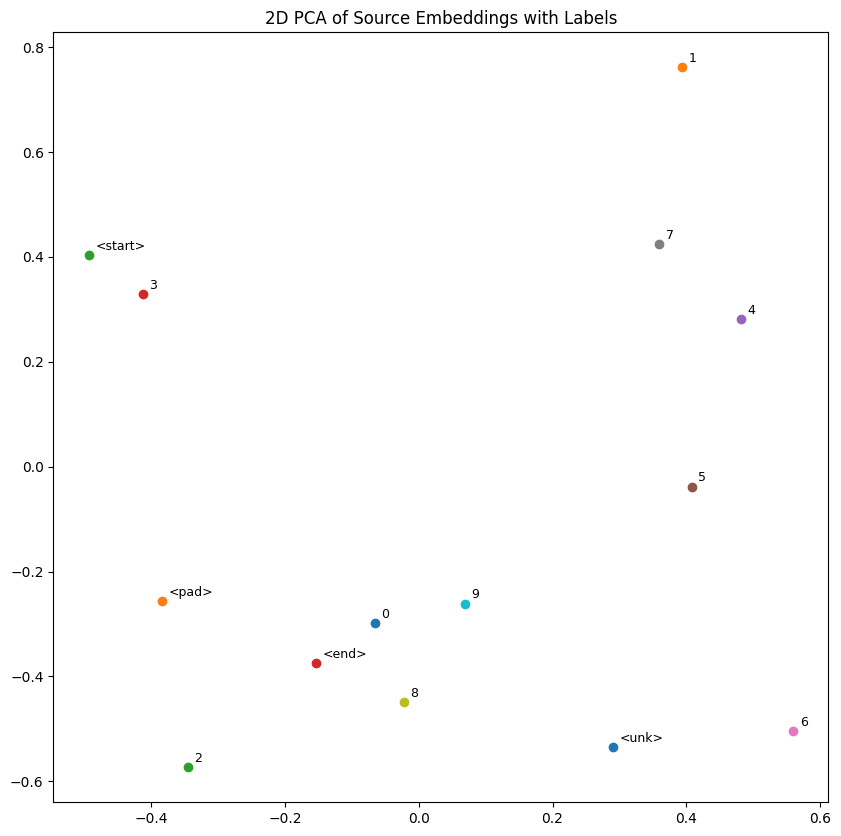

In [99]:
embedding_tgt_cpu = embedding_tgt_weight.cpu().detach()
print(embedding_tgt_cpu[: , :2])

# 逆辞書を作成してインデックスを文字に変換
reverse_vocab_src = {idx: token for token, idx in vocab_tgt.items()}

# 可視化
plt.figure(figsize=(10, 10))

# 各ポイントを散布図でプロットし、対応するラベルを表示
for i, (x, y) in enumerate(embedding_tgt_cpu[:, :2]):  # [:, :2]をスライスし、次にenumerate
    label = reverse_vocab_src[i]  # インデックスを元のトークンに戻す
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)  # 各点の近くにラベルを表示

plt.title("2D PCA of Source Embeddings with Labels")
plt.show()

## Attentionを確認

In [97]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '845'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_src_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(10):
    tgt_embed = positional_encoding(embedding_tgt_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    # visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_tgt)
    # Memory-Attentionの可視化
    # visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    
    # Feedforward network

    # decoder linear1, 2
    tgt2 = tgt.matmul(linear1_weight.T) + linear1_bias
    tgt2 = F.relu(tgt2)
    tgt2 = tgt2.matmul(linear2_weight.T) + linear2_bias
    tgt = tgt + tgt2

    # LayerNorm
    tgt = loaded_model.decoder_layer.norm3(tgt)

    output = tgt.transpose(0, 1)
    output = loaded_model.output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"AfterLinear.shape: {tgt2.shape}")
    print(f"AfterAddTGT.shape: {tgt.shape}")
    print(f"AfterAddTGT: {tgt}")
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

text: 845
memory: tensor([[[-0.1629,  2.0443, -1.4842,  1.9065]],

        [[ 0.1105,  0.5747,  0.3388,  0.7371]],

        [[ 0.8851,  0.3614,  0.5298, -0.7286]],

        [[ 1.0279,  1.0335,  1.3987,  1.6276]],

        [[ 0.9010, -1.1333,  1.1937,  2.0909]]], device='cuda:0')
memory_size: torch.Size([5, 1, 4])

------------------

iter: 0
ys: tensor([[12]], device='cuda:0')
tgt_embed: tensor([[[-0.9863,  1.8076,  0.7004,  1.2708]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[-0.9863,  1.8076,  0.7004,  1.2708]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 1, 4])
WV.shape: torch.Size([1, 1, 4])
attn_weight.shape: torch.Size([1, 1, 1])
AV.shape: torch.Size([1, 1, 4])
self_attention: 
[[1.]]
tgt_tokens: ['<start>']
QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 5, 4])
WV.shape: torch.Size([1, 5, 4])
attn_weight.shape: torch.Size([1, 1, 5])
AV.shape: torch.Size([1, 1, 4])
multi_attention: 
[[0.216076   0.3460155  0.265307

text: 845
memory: tensor([[[-0.1629,  2.0443, -1.4842,  1.9065]],

        [[ 0.1105,  0.5747,  0.3388,  0.7371]],

        [[ 0.8851,  0.3614,  0.5298, -0.7286]],

        [[ 1.0279,  1.0335,  1.3987,  1.6276]],

        [[ 0.9010, -1.1333,  1.1937,  2.0909]]], device='cuda:0')
memory_size: torch.Size([5, 1, 4])

------------------

iter: 0
ys: tensor([[12]], device='cuda:0')
tgt_embed: tensor([[[-0.9863,  1.8076,  0.7004,  1.2708]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[-0.9863,  1.8076,  0.7004,  1.2708]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 1, 4])
WV.shape: torch.Size([1, 1, 4])
attn_weight.shape: torch.Size([1, 1, 1])
AV.shape: torch.Size([1, 1, 4])
self_attention: 
[[1.]]
tgt_tokens: ['<start>']


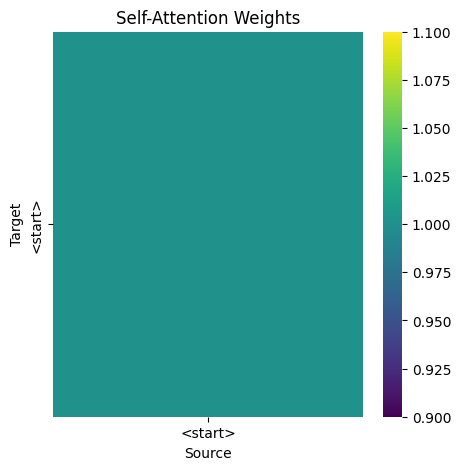

QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 5, 4])
WV.shape: torch.Size([1, 5, 4])
attn_weight.shape: torch.Size([1, 1, 5])
AV.shape: torch.Size([1, 1, 4])
multi_attention: 
[[0.216076   0.3460155  0.26530796 0.09342545 0.07917511]]


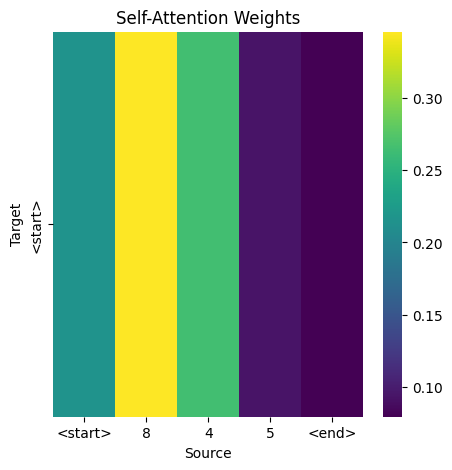

AfterLinear.shape: torch.Size([1, 1, 4])
AfterAddTGT.shape: torch.Size([1, 1, 4])
AfterAddTGT: tensor([[[-2.0120, -3.8371, -0.5327,  4.4006]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 14])
output: tensor([[ 0.2146, 18.0055,  1.0624, -1.4356, -1.2479, -1.9981, -2.7252,  0.5598, -1.2562, -0.1687,
         -0.2285, -1.2345, -2.3373, -9.1376]], device='cuda:0', grad_fn=<AddmmBackward0>)
predicted: 1

------------------

iter: 1
ys: tensor([[12],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[-0.9863,  1.8076,  0.7004,  1.2708]],

        [[ 1.6270,  2.0634,  1.2402, -0.3692]]], device='cuda:0')
now tgt: 1
tgt_embed: tensor([[[-0.9863,  1.8076,  0.7004,  1.2708]],

        [[ 1.6270,  2.0634,  1.2402, -0.3692]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 2, 4])
WV.shape: torch.Size([1, 2, 4])
attn_weight.shape: torch.Size([1, 2, 2])
AV.shape: torch.Size([1, 2, 4])
self_attention: 
[[0.

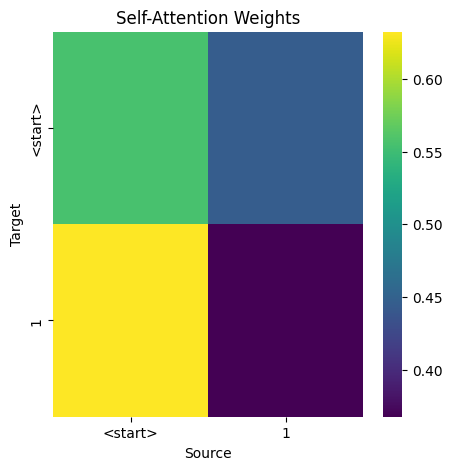

QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 5, 4])
WV.shape: torch.Size([1, 5, 4])
attn_weight.shape: torch.Size([1, 2, 5])
AV.shape: torch.Size([1, 2, 4])
multi_attention: 
[[0.20410535 0.35008988 0.27891067 0.08962701 0.0772671 ]
 [0.21153116 0.23744078 0.2332023  0.16336957 0.15445627]]


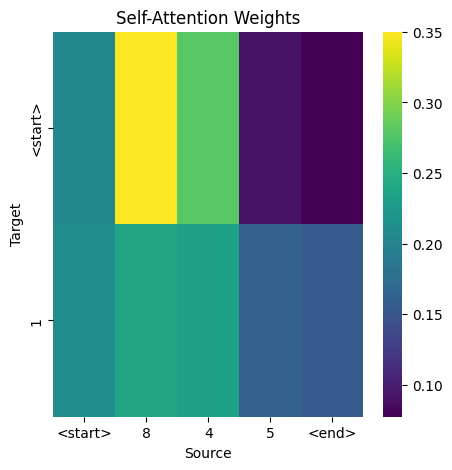

AfterLinear.shape: torch.Size([2, 1, 4])
AfterAddTGT.shape: torch.Size([2, 1, 4])
AfterAddTGT: tensor([[[-1.9498, -3.5689, -0.9545,  4.6952]],

        [[ 3.6856, -0.9817, -0.9830, -2.5044]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 14])
output: tensor([[-7.9018, -4.5903, -2.8430, -4.3944, -4.0620, -4.4787, -4.8172, -3.4743, -4.0386, -3.7189,
         -3.3038, -3.7433, -3.8429, 12.1664]], device='cuda:0', grad_fn=<AddmmBackward0>)
predicted: 13

------------------

Input: 845
Decoded sequence: 1


In [98]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '845'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_src_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(10):
    tgt_embed = positional_encoding(embedding_tgt_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_tgt)
    # Memory-Attentionの可視化
    visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    
    # Feedforward network

    # decoder linear1, 2
    tgt2 = tgt.matmul(linear1_weight.T) + linear1_bias
    tgt2 = F.relu(tgt2)
    tgt2 = tgt2.matmul(linear2_weight.T) + linear2_bias
    tgt = tgt + tgt2

    # LayerNorm
    tgt = loaded_model.decoder_layer.norm3(tgt)

    output = tgt.transpose(0, 1)
    output = loaded_model.output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"AfterLinear.shape: {tgt2.shape}")
    print(f"AfterAddTGT.shape: {tgt.shape}")
    print(f"AfterAddTGT: {tgt}")
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

## TGTのベクトル移動を観察

tensor([[-0.2459, -0.3462],
        [ 0.2268,  0.4715],
        [-0.2492,  0.0787],
        [ 0.3967,  0.6070],
        [-0.0121,  0.3887],
        [ 0.4434,  1.0117],
        [-0.5530, -0.1583],
        [ 0.0951,  0.1892],
        [-0.3655,  0.0172],
        [ 0.2834,  0.3894],
        [ 0.1483, -0.1588],
        [ 0.4688, -0.4443],
        [-0.0815,  0.5221],
        [ 0.8289, -0.2398]])
tensor([[-0.0654, -0.2982],
        [ 0.3928,  0.7616],
        [-0.3449, -0.5731],
        [-0.4126,  0.3292],
        [ 0.4813,  0.2821],
        [ 0.4080, -0.0379],
        [ 0.5595, -0.5041],
        [ 0.3590,  0.4244],
        [-0.0226, -0.4489],
        [ 0.0693, -0.2612],
        [ 0.2897, -0.5343],
        [-0.3838, -0.2568],
        [-0.4932,  0.4038],
        [-0.1535, -0.3741]])


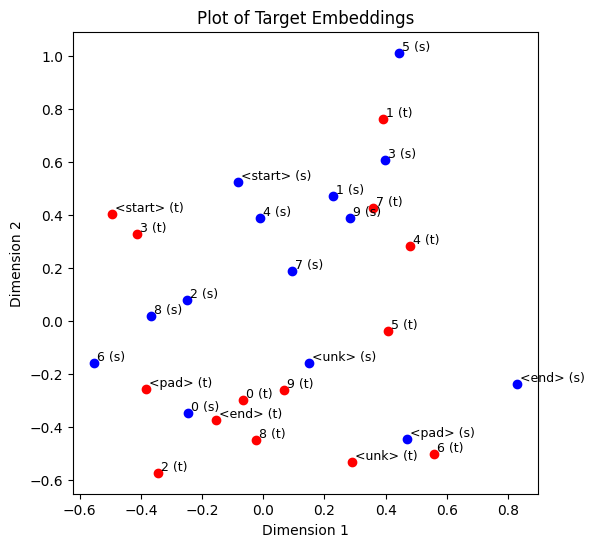

In [187]:
import numpy as np
embedding_src_cpu_01dim = embedding_src_weight.cpu().detach()[: , :2]
embedding_tgt_cpu_01dim = embedding_tgt_weight.cpu().detach()[: , :2]
print(embedding_src_cpu_01dim)
print(embedding_tgt_cpu_01dim)

reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}
reverse_vocab_tgt = {idx: token for token, idx in vocab_tgt.items()}

def plot_embedding_tgt_2d(ys=None, tgt_embed=None, src=None, title="Target Embeddings"):
    plt.figure(figsize=(6, 6))

    # src
    for i, (x, y) in enumerate(embedding_src_cpu_01dim):
        label = reverse_vocab_src[i] + " (s)"
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, label, fontsize=9) 
    # tgt
    for i, (x, y) in enumerate(embedding_tgt_cpu_01dim):
        label = reverse_vocab_tgt[i] + " (t)"
        plt.scatter(x, y, color='red')
        plt.text(x + 0.01, y + 0.01, label, fontsize=9) 

    if tgt_embed is not None:
        tgt_embed = tgt_embed.detach().cpu().numpy()
        print(tgt_embed)
        print(tgt_embed.shape)
        if len(tgt_embed.shape) > 2:
            if tgt_embed.shape[0] == 1:
                tgt_embed = np.squeeze(tgt_embed, axis=0)
            elif tgt_embed.shape[1] == 1:
                tgt_embed = np.squeeze(tgt_embed, axis=1)
        tgt_embed_2d = tgt_embed[:, :2]
        print(tgt_embed_2d)
        for i, (x, y) in enumerate(tgt_embed_2d):
            if src is not None:
                label = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)[i] + " (s)"
            else:
                label = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)[i] + " (t)"
            plt.scatter(x, y, color='green', s=100, marker='x')
            plt.text(x + 0.01, y + 0.01, label, fontsize=9)

    plt.title(f"Plot of {title}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


plot_embedding_tgt_2d()

text: 846
memory: tensor([[[-0.1629,  2.0443, -1.4842,  1.9065]],

        [[ 0.1105,  0.5747,  0.3388,  0.7371]],

        [[ 0.8851,  0.3614,  0.5298, -0.7286]],

        [[-0.9650, -1.3066,  0.2885,  1.5175]],

        [[ 0.9010, -1.1333,  1.1937,  2.0909]]], device='cuda:0')
memory_size: torch.Size([5, 1, 4])

------------------

iter: 0
ys: tensor([[12]], device='cuda:0')
tgt_embed: tensor([[[-0.9863,  1.8076,  0.7004,  1.2708]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[-0.9863,  1.8076,  0.7004,  1.2708]]], device='cuda:0')
[[[-0.49315998  0.4038112   0.35021392  0.13537923]]]
(1, 1, 4)
[[-0.49315998  0.4038112 ]]


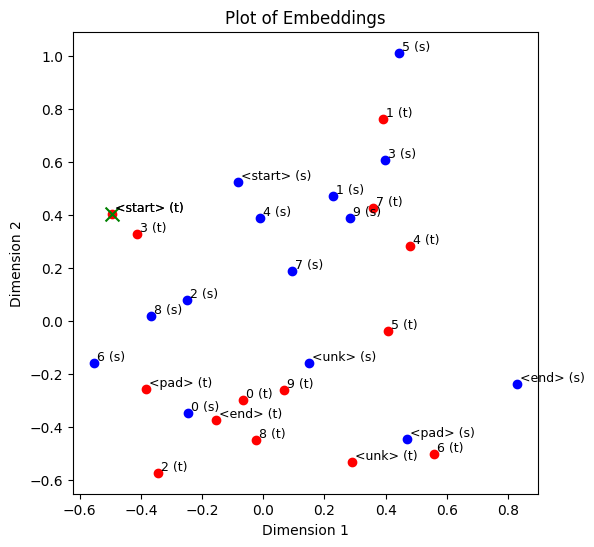

[[[-0.98631996  1.8076224   0.70042783  1.2707584 ]]]
(1, 1, 4)
[[-0.98631996  1.8076224 ]]


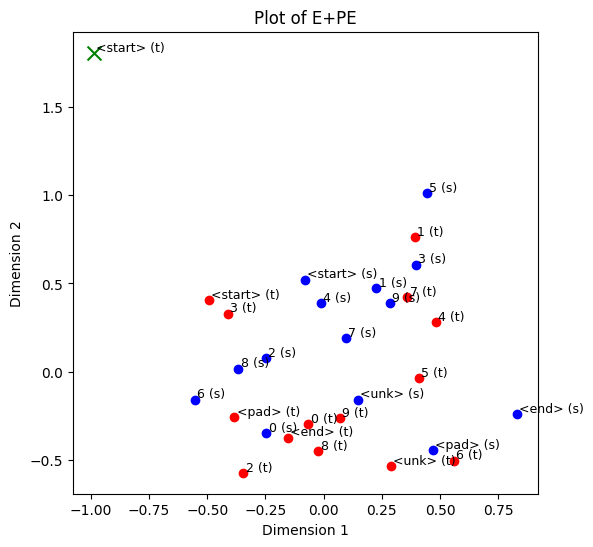

SelfAttention Layer
QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 1, 4])
WV.shape: torch.Size([1, 1, 4])
attn_weight.shape: torch.Size([1, 1, 1])
AV.shape: torch.Size([1, 1, 4])
[[[-0.58866376 -1.7726312  -0.4420283  -1.3785932 ]]]
(1, 1, 4)
[[-0.58866376 -1.7726312 ]]


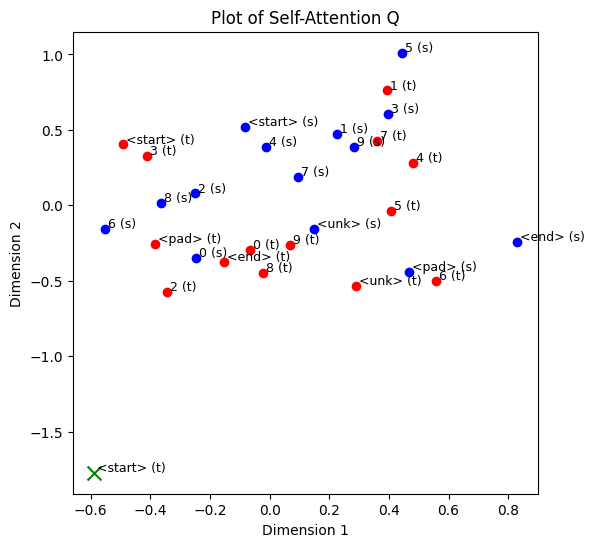

[[[ 1.6863718   0.84328574 -0.91657674  1.922781  ]]]
(1, 1, 4)
[[1.6863718  0.84328574]]


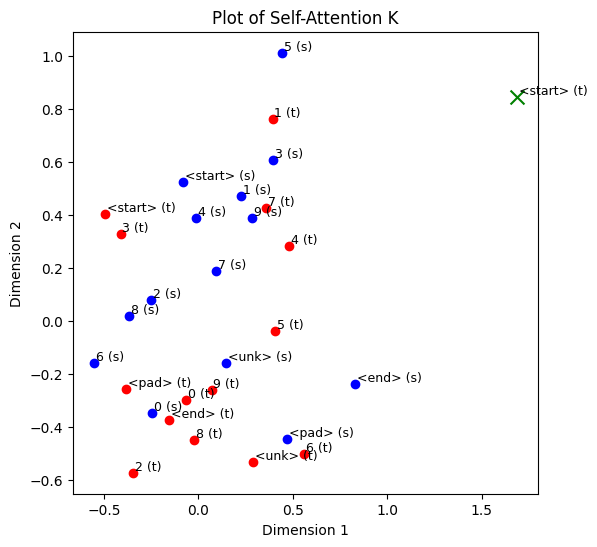

[[[0.82678074 1.1230366  0.61497813 1.3498744 ]]]
(1, 1, 4)
[[0.82678074 1.1230366 ]]


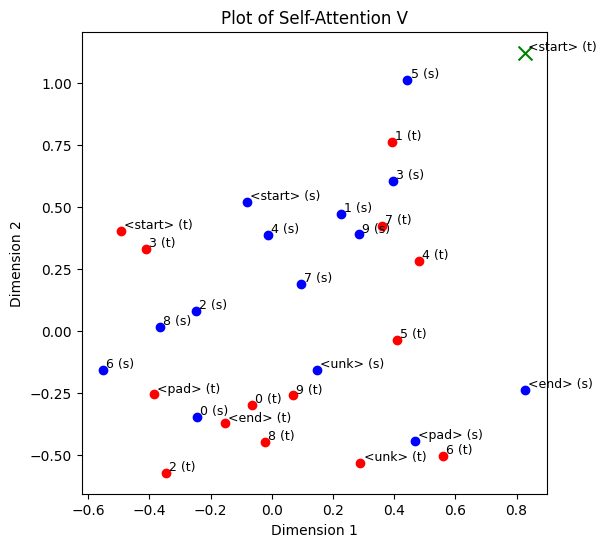

[[[0.82678074 1.1230366  0.61497813 1.3498744 ]]]
(1, 1, 4)
[[0.82678074 1.1230366 ]]


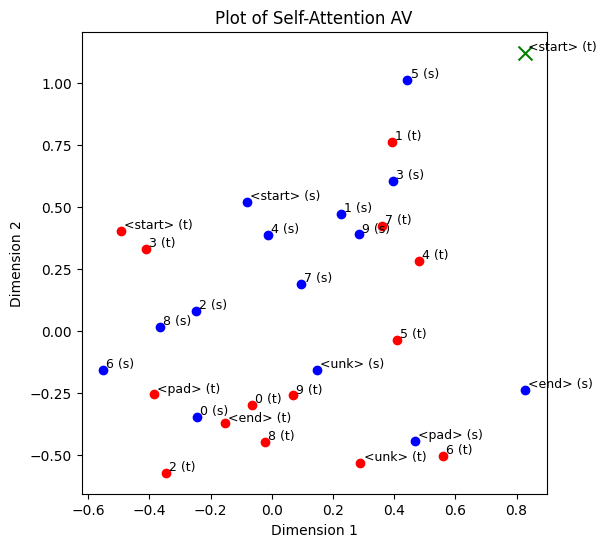

[[[-1.7328085  -0.42813447 -1.322246   -0.16436546]]]
(1, 1, 4)
[[-1.7328085  -0.42813447]]


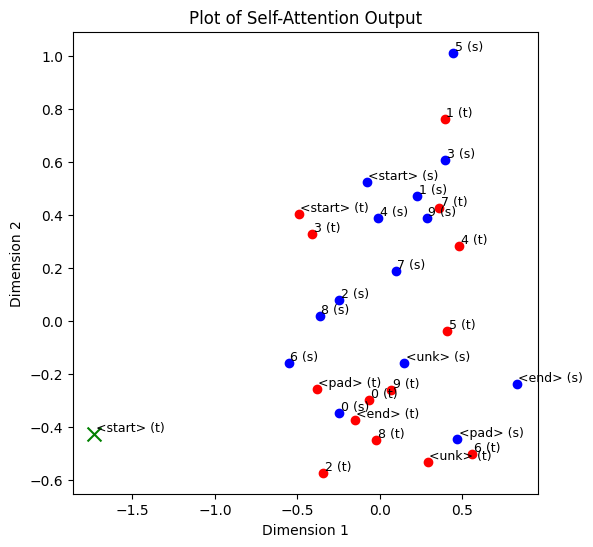

[[[-1.4422634   0.94011366 -0.15660487  0.9449387 ]]]
(1, 1, 4)
[[-1.4422634   0.94011366]]


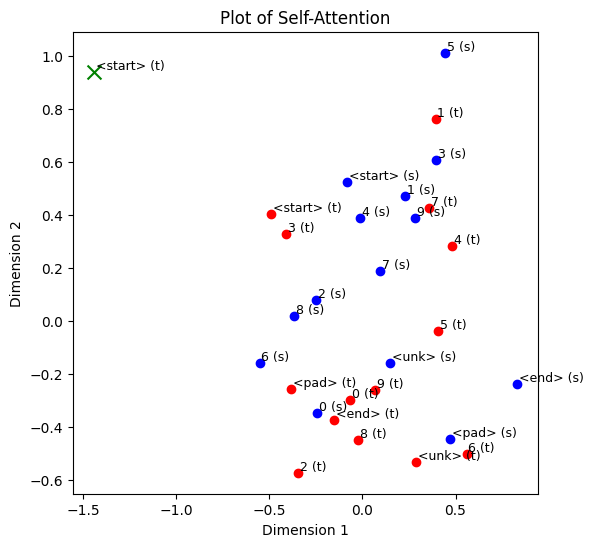

QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 5, 4])
WV.shape: torch.Size([1, 5, 4])
attn_weight.shape: torch.Size([1, 1, 5])
AV.shape: torch.Size([1, 1, 4])
[[[-1.9854372   0.9270647   1.590159   -0.38320428]]]
(1, 1, 4)
[[-1.9854372  0.9270647]]


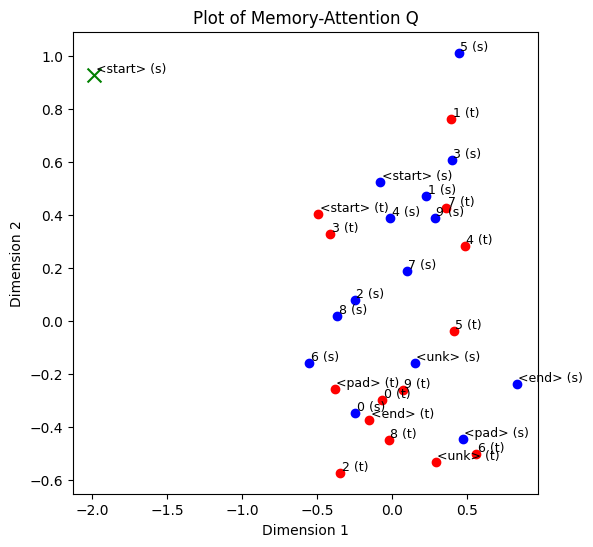

[[ 0.9662032   0.34086674  0.64177144  2.3004708 ]
 [ 0.2681104  -0.46722624  0.5011739   0.9215346 ]
 [-0.23124874 -1.0311465  -0.3428924   0.02812274]
 [ 0.41875577  1.0457125   0.6953405  -0.04808763]
 [ 1.2251798  -0.6267572  -0.03099876  1.0658636 ]]
(5, 4)
[[ 0.9662032   0.34086674]
 [ 0.2681104  -0.46722624]
 [-0.23124874 -1.0311465 ]
 [ 0.41875577  1.0457125 ]
 [ 1.2251798  -0.6267572 ]]


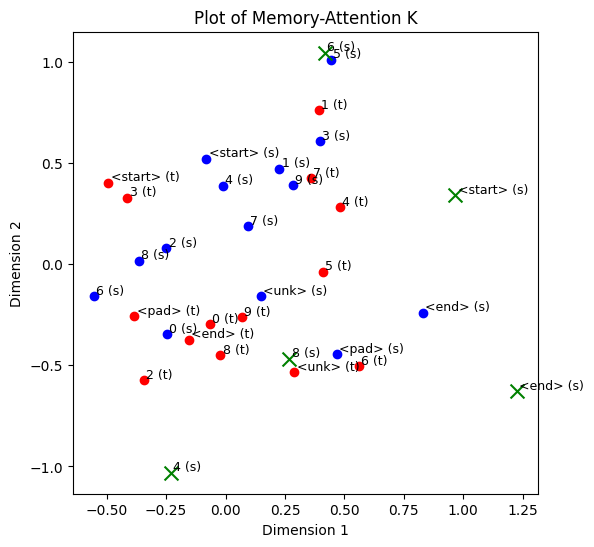

[[-1.4602922   0.5095478  -1.1268754  -0.04959427]
 [ 0.20383094 -0.463549   -0.8345419   0.7427077 ]
 [ 1.1553686  -0.4864829  -0.45007262  0.32213348]
 [-0.7599221  -0.2555294   0.2627006   1.0177591 ]
 [ 0.2324854  -0.45900795 -1.1529813   2.6288068 ]]
(5, 4)
[[-1.4602922   0.5095478 ]
 [ 0.20383094 -0.463549  ]
 [ 1.1553686  -0.4864829 ]
 [-0.7599221  -0.2555294 ]
 [ 0.2324854  -0.45900795]]


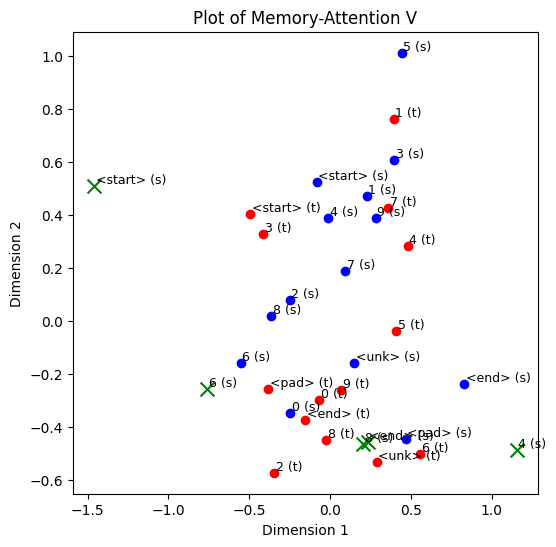

[[-0.32077044 -0.24641767 -0.29768422  0.7991122 ]]
(1, 4)
[[-0.32077044 -0.24641767]]


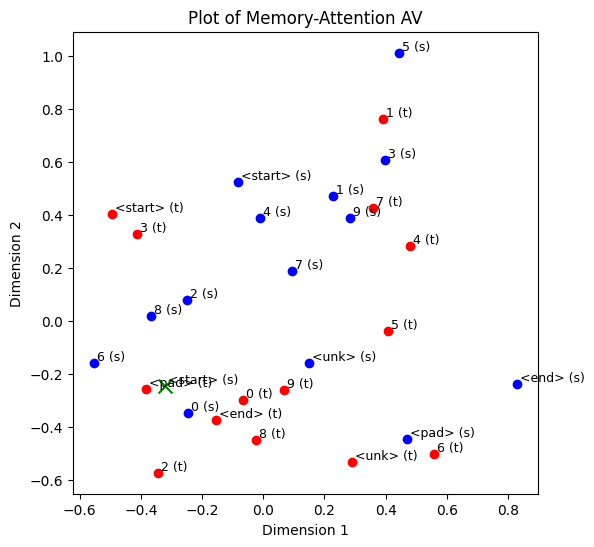

[[[-1.7328085  -0.42813447 -1.322246   -0.16436546]]]
(1, 1, 4)
[[-1.7328085  -0.42813447]]


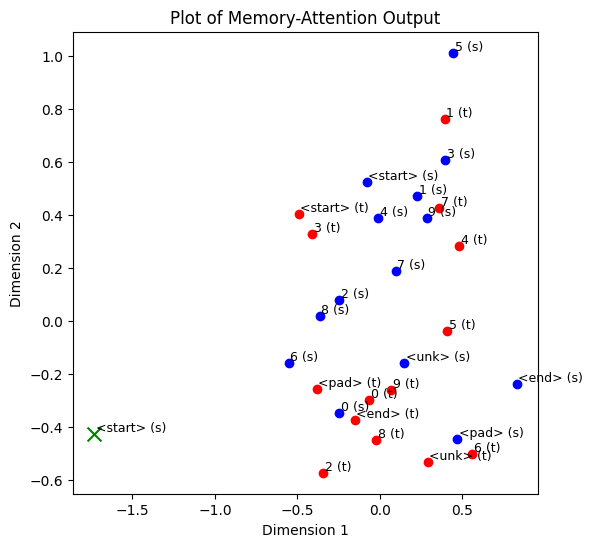

[[[-1.724667    0.12489834  0.13704382  1.0709795 ]]]
(1, 1, 4)
[[-1.724667    0.12489834]]


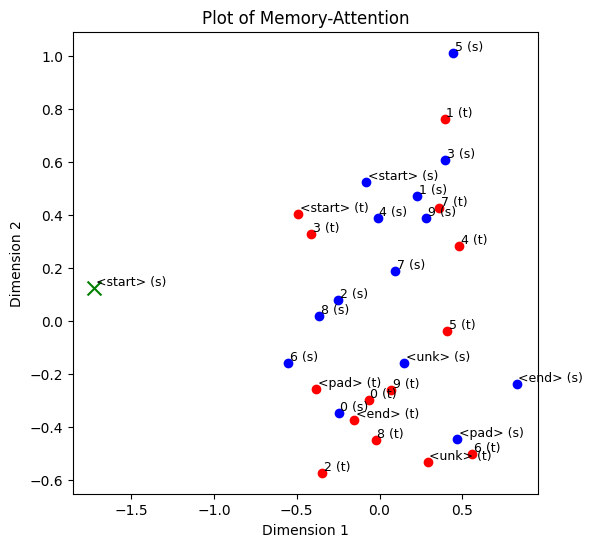

AfterLinear.shape: torch.Size([1, 1, 4])
AfterAddTGT.shape: torch.Size([1, 1, 4])
AfterAddTGT: tensor([[[-3.7289,  3.5403, -0.9392,  0.3655]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 14])
output: tensor([[14.9745, -3.5026,  0.9757, -0.7818, -0.4794, -0.9550, -1.3675,  0.3336, -0.4406, -0.0376,
          0.3103, -0.2213, -0.5698, -6.1704]], device='cuda:0', grad_fn=<AddmmBackward0>)
predicted: 0

------------------

iter: 1
ys: tensor([[12],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[-0.9863,  1.8076,  0.7004,  1.2708]],

        [[ 0.7106, -0.0560, -0.4532, -2.0420]]], device='cuda:0')
now tgt: 0
tgt_embed: tensor([[[-0.9863,  1.8076,  0.7004,  1.2708]],

        [[ 0.7106, -0.0560, -0.4532, -2.0420]]], device='cuda:0')
[[[-0.49315998  0.4038112   0.35021392  0.13537923]]

 [[-0.06541439 -0.29815122 -0.23160395 -1.5209858 ]]]
(2, 1, 4)
[[-0.49315998  0.4038112 ]
 [-0.06541439 -0.29815122]]


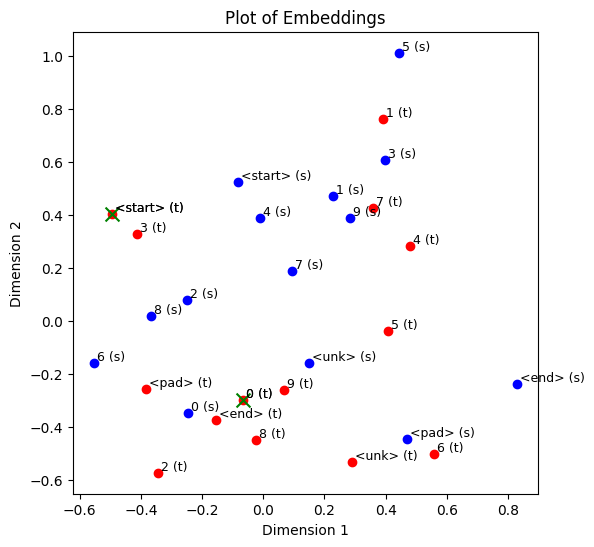

[[[-0.98631996  1.8076224   0.70042783  1.2707584 ]]

 [[ 0.71064216 -0.05600011 -0.45320806 -2.0420218 ]]]
(2, 1, 4)
[[-0.98631996  1.8076224 ]
 [ 0.71064216 -0.05600011]]


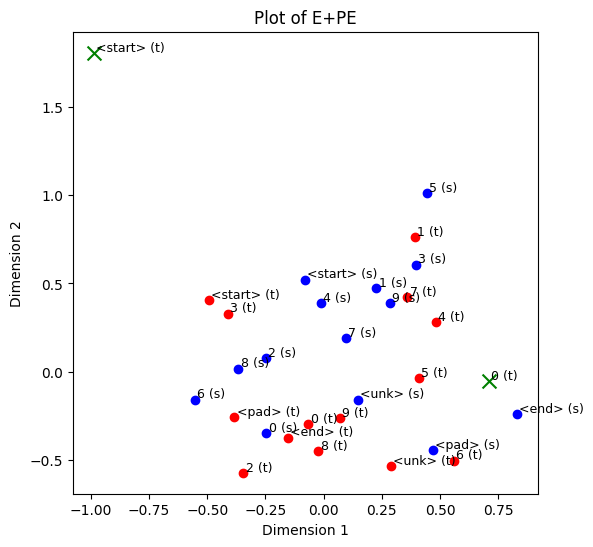

SelfAttention Layer
QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 2, 4])
WV.shape: torch.Size([1, 2, 4])
attn_weight.shape: torch.Size([1, 2, 2])
AV.shape: torch.Size([1, 2, 4])
[[[-0.58866376 -1.772631   -0.4420283  -1.3785932 ]
  [ 1.3283346   1.1196104   0.08883237  0.9347685 ]]]
(1, 2, 4)
[[-0.58866376 -1.772631  ]
 [ 1.3283346   1.1196104 ]]


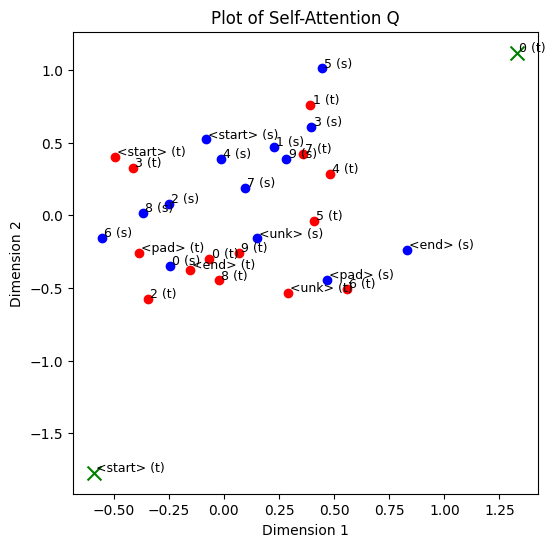

[[[ 1.6863719   0.84328574 -0.91657674  1.9227809 ]
  [-2.2493258   0.54569656  1.1434032   0.09818362]]]
(1, 2, 4)
[[ 1.6863719   0.84328574]
 [-2.2493258   0.54569656]]


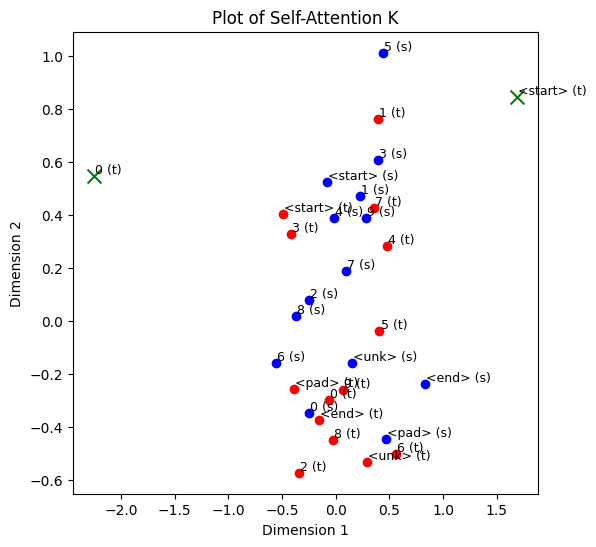

[[[ 0.82678074  1.1230366   0.6149782   1.3498744 ]
  [-0.6983896  -0.5798952  -0.10786912 -0.34604472]]]
(1, 2, 4)
[[ 0.82678074  1.1230366 ]
 [-0.6983896  -0.5798952 ]]


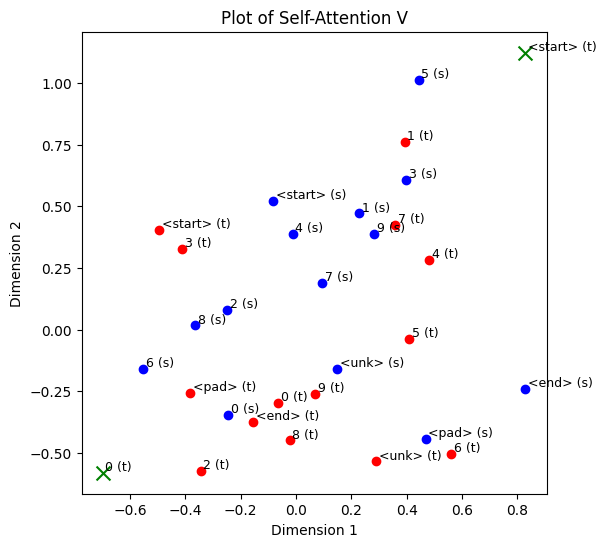

[[[-0.54958445 -0.4137465  -0.03734361 -0.18058026]
  [ 0.7838552   1.0751079   0.5946338   1.3021431 ]]]
(1, 2, 4)
[[-0.54958445 -0.4137465 ]
 [ 0.7838552   1.0751079 ]]


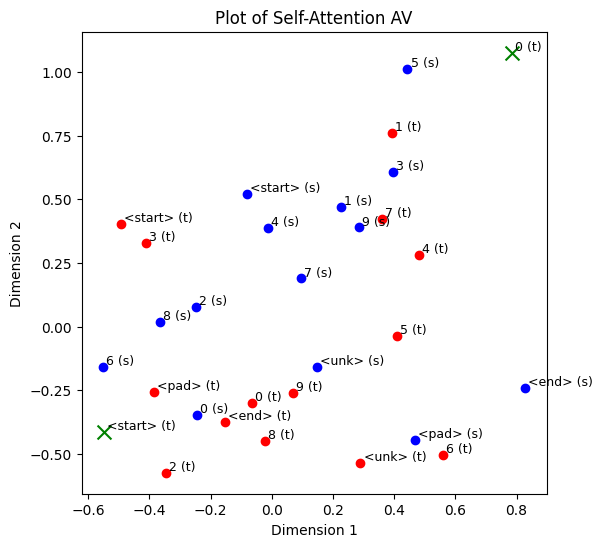

[[[ 0.76092273  0.14580065  0.11165462  0.318384  ]]

 [[-1.6550347  -0.4102348  -1.2775259  -0.14930971]]]
(2, 1, 4)
[[ 0.76092273  0.14580065]
 [-1.6550347  -0.4102348 ]]


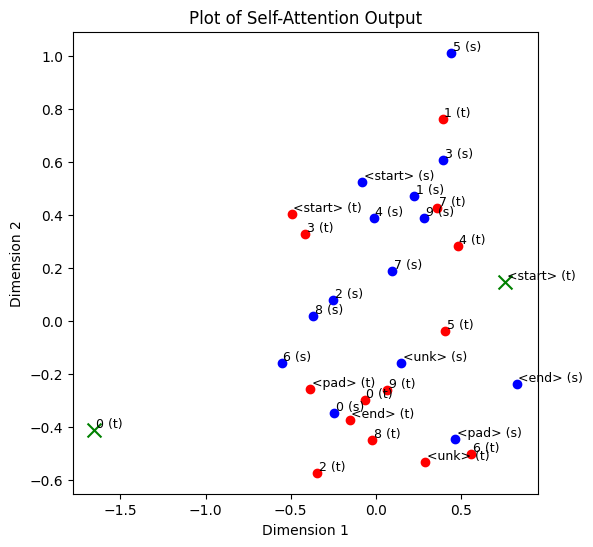

[[[-1.4182652   1.0710611  -0.16612685  0.79059154]]

 [[ 0.68398833  1.2624983  -0.38171428 -1.3656657 ]]]
(2, 1, 4)
[[-1.4182652   1.0710611 ]
 [ 0.68398833  1.2624983 ]]


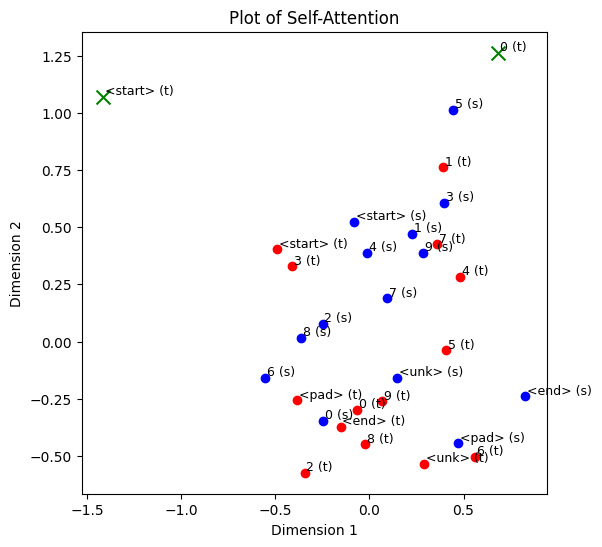

QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 5, 4])
WV.shape: torch.Size([1, 5, 4])
attn_weight.shape: torch.Size([1, 2, 5])
AV.shape: torch.Size([1, 2, 4])
[[[-1.9547207   0.92562395  1.5303737  -0.33932117]
  [-0.14683303 -0.08377668 -0.13123968 -0.05526533]]]
(1, 2, 4)
[[-1.9547207   0.92562395]
 [-0.14683303 -0.08377668]]


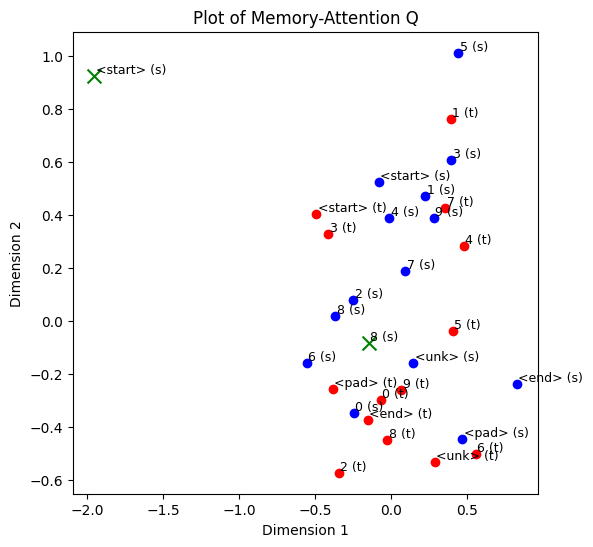

[[ 0.9662032   0.34086674  0.64177144  2.3004708 ]
 [ 0.2681104  -0.46722624  0.5011739   0.9215346 ]
 [-0.23124874 -1.0311465  -0.3428924   0.02812274]
 [ 0.41875577  1.0457125   0.6953405  -0.04808763]
 [ 1.2251798  -0.6267572  -0.03099876  1.0658636 ]]
(5, 4)
[[ 0.9662032   0.34086674]
 [ 0.2681104  -0.46722624]
 [-0.23124874 -1.0311465 ]
 [ 0.41875577  1.0457125 ]
 [ 1.2251798  -0.6267572 ]]


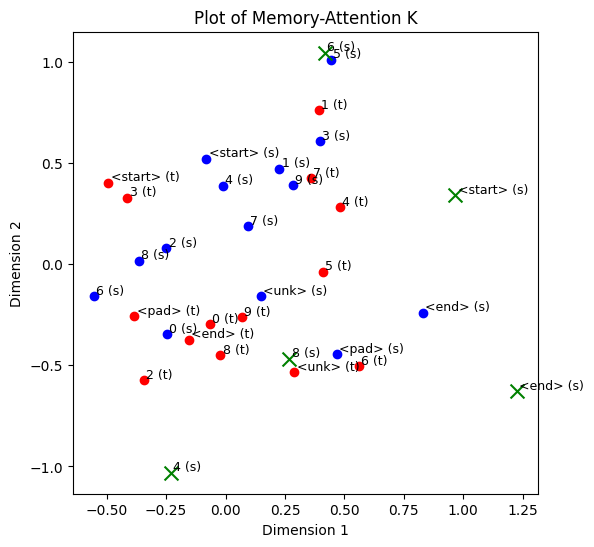

[[-1.4602922   0.5095478  -1.1268754  -0.04959427]
 [ 0.20383094 -0.463549   -0.8345419   0.7427077 ]
 [ 1.1553686  -0.4864829  -0.45007262  0.32213348]
 [-0.7599221  -0.2555294   0.2627006   1.0177591 ]
 [ 0.2324854  -0.45900795 -1.1529813   2.6288068 ]]
(5, 4)
[[-1.4602922   0.5095478 ]
 [ 0.20383094 -0.463549  ]
 [ 1.1553686  -0.4864829 ]
 [-0.7599221  -0.2555294 ]
 [ 0.2324854  -0.45900795]]


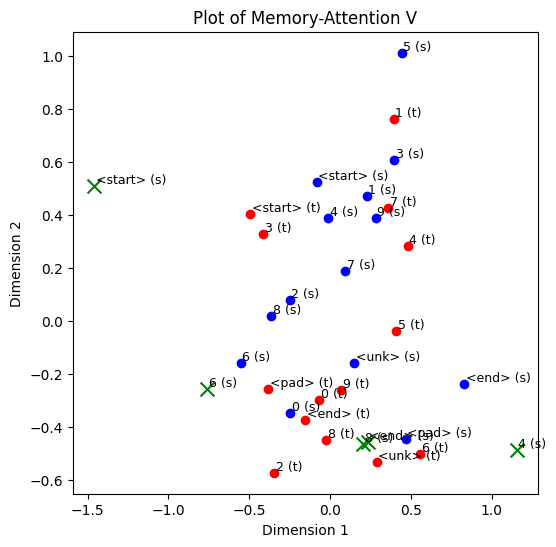

[[-0.32004702 -0.24311765 -0.30972594  0.7955078 ]
 [-0.04786179 -0.25563824 -0.64996314  0.9263554 ]]
(2, 4)
[[-0.32004702 -0.24311765]
 [-0.04786179 -0.25563824]]


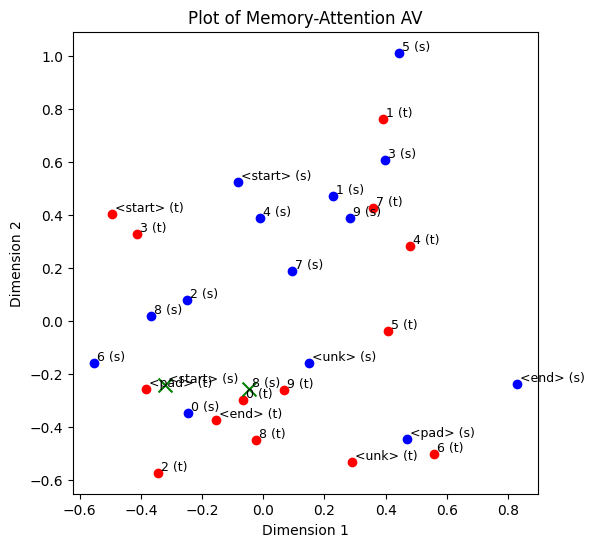

[[[ 0.76092273  0.14580065  0.11165462  0.318384  ]]

 [[-1.6550347  -0.4102348  -1.2775259  -0.14930971]]]
(2, 1, 4)
[[ 0.76092273  0.14580065]
 [-1.6550347  -0.4102348 ]]


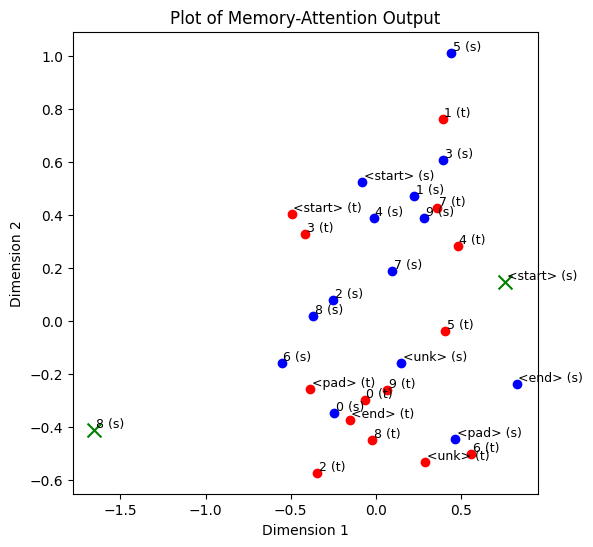

[[[-1.8284018   0.43840194  0.12799314  0.9122698 ]]

 [[ 1.5436449   0.06498729 -0.01452946 -1.478392  ]]]
(2, 1, 4)
[[-1.8284018   0.43840194]
 [ 1.5436449   0.06498729]]


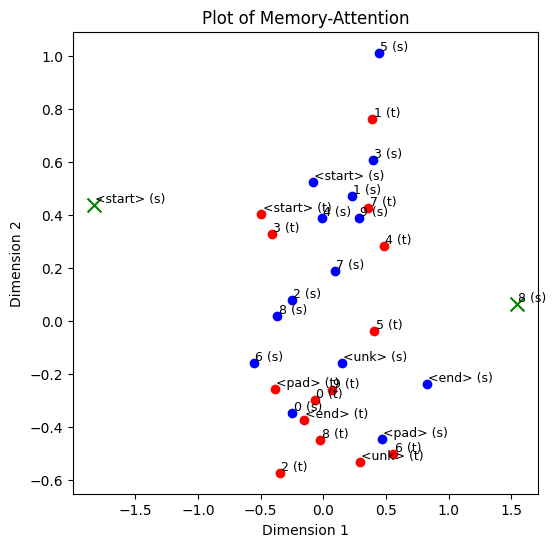

AfterLinear.shape: torch.Size([2, 1, 4])
AfterAddTGT.shape: torch.Size([2, 1, 4])
AfterAddTGT: tensor([[[-2.5395,  4.1160, -1.2343, -0.7853]],

        [[ 3.7951, -1.1127, -1.0516, -2.4010]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 14])
output: tensor([[-8.1598, -4.1944, -2.9230, -4.5244, -4.2025, -4.6597, -5.0254, -3.5335, -4.1913, -3.7902,
         -3.4265, -3.9190, -4.0972, 12.1679]], device='cuda:0', grad_fn=<AddmmBackward0>)
predicted: 13

------------------

Input: 846
Decoded sequence: 0


In [189]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '846'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_src_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(10):
    tgt_embed = positional_encoding(embedding_tgt_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=embedding_tgt_weight[ys], title="Embeddings")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt_embed, title="E+PE")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    # Self-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(ys=ys, tgt_embed=QW, title="Self-Attention Q")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=KW, title="Self-Attention K")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=VW, title="Self-Attention V")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=AV, title="Self-Attention AV")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=self_attn_output, title="Self-Attention Output")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt, title="Self-Attention")

    


    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    # Memory-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(ys=ys, tgt_embed=QW, src=src, title="Memory-Attention Q")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=np.squeeze(KW, axis=0), src=src, title="Memory-Attention K")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=np.squeeze(VW, axis=0), src=src, title="Memory-Attention V")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=np.squeeze(AV, axis=0), src=src, title="Memory-Attention AV")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=multi_attn_output, src=src, title="Memory-Attention Output")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt, src=src, title="Memory-Attention")



    # Feedforward network

    # decoder linear1, 2
    tgt2 = tgt.matmul(linear1_weight.T) + linear1_bias
    tgt2 = F.relu(tgt2)
    tgt2 = tgt2.matmul(linear2_weight.T) + linear2_bias
    tgt = tgt + tgt2

    # LayerNorm
    tgt = loaded_model.decoder_layer.norm3(tgt)

    output = tgt.transpose(0, 1)
    output = loaded_model.output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"AfterLinear.shape: {tgt2.shape}")
    print(f"AfterAddTGT.shape: {tgt.shape}")
    print(f"AfterAddTGT: {tgt}")
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

# Transformerの検算

スクラッチで書くための検算

## Multihead Attention

Multihead Attentionの動作をスクラッチで書きたいので、ここで検算する

参考サイト
https://blog.amedama.jp/entry/pytorch-multi-head-attention-verify

In [30]:
import torch
from torch import nn
import torch.nn.functional as F


In [31]:
edim = 4 # 埋め込み次元
num_heads = 1 # ヘッド数
model = nn.MultiheadAttention(edim, num_heads, bias=True, batch_first=True)

In [32]:
batch_size = 2
L=5
X = torch.randn(batch_size, L, edim) # 入力

Q = K = V = X # クエリ、キー、バリューは全て入力とする
print(Q.shape)
print(Q)

torch.Size([2, 5, 4])
tensor([[[-0.6987, -0.3834,  1.2682, -0.9115],
         [ 0.1152,  0.0263,  1.2358,  0.0605],
         [ 0.3132, -0.8764,  0.0898, -1.3914],
         [-0.4325, -0.9414,  0.4386, -1.1127],
         [-1.1277,  0.8637, -0.3704, -0.0910]],

        [[ 2.1964, -1.9274, -0.2268,  0.4893],
         [-0.2748,  1.1336,  0.2190, -0.6835],
         [-0.1141, -0.4967, -1.3600,  0.2523],
         [ 0.3653,  2.9546,  0.3290, -0.3951],
         [ 0.8593,  0.6910, -0.5978,  1.4734]]])


In [33]:

attn_output, attn_output_weights = model(Q, K, V)

print(attn_output.shape)
print(attn_output)



torch.Size([2, 5, 4])
tensor([[[ 0.2059, -0.4056,  0.2160, -0.0673],
         [ 0.1822, -0.3807,  0.2070, -0.0473],
         [ 0.1560, -0.4002,  0.2226, -0.0127],
         [ 0.1659, -0.3980,  0.2178, -0.0270],
         [ 0.1697, -0.3473,  0.1753, -0.0671]],

        [[-0.9989,  0.7810, -0.2646,  0.8636],
         [ 0.3898,  0.4143, -0.4019, -0.7050],
         [-0.5618,  0.6062, -0.2746,  0.3864],
         [ 0.5713,  0.4507, -0.4685, -0.9366],
         [-0.6284,  0.6691, -0.2853,  0.4612]]], grad_fn=<TransposeBackward0>)


In [34]:
from pprint import pprint
pprint(list(model.named_parameters()))

[('in_proj_weight',
  Parameter containing:
tensor([[ 1.6164e-01, -5.7244e-01,  9.6066e-03, -5.3087e-01],
        [ 3.5323e-01, -2.8011e-01, -2.6955e-01,  5.0069e-01],
        [-4.8172e-01,  5.8581e-01, -3.8958e-02,  2.4328e-01],
        [ 4.8875e-01, -5.1309e-01,  4.8611e-01, -5.8679e-01],
        [-1.9868e-01, -3.2428e-01,  6.5746e-03, -5.0330e-01],
        [ 5.2913e-01, -5.8652e-01,  2.9461e-02,  1.4236e-01],
        [ 1.6880e-01,  3.3092e-01,  2.6239e-01, -6.1039e-01],
        [ 3.1390e-04,  2.2849e-01,  4.5257e-01, -1.0142e-01],
        [-5.8239e-01,  4.9897e-01,  5.1502e-01,  3.9330e-02],
        [ 3.2820e-01,  4.2034e-01, -5.4201e-01, -4.6981e-01],
        [-4.5807e-01, -4.7335e-01, -2.1864e-01, -3.4159e-01],
        [-2.4120e-01,  4.2626e-01, -2.9527e-01, -5.8191e-01]], requires_grad=True)),
 ('in_proj_bias',
  Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)),
 ('out_proj.weight',
  Parameter containing:
tensor([[ 0.4081, -0.33

In [35]:
model_weight = {name: param.data for name, param in model.named_parameters()}
Wi = model_weight['in_proj_weight']
Wo = model_weight['out_proj.weight']
Wbi = model_weight['in_proj_bias']
Wbo = model_weight['out_proj.bias']

In [36]:
Wi_q, Wi_k, Wi_v = Wi.chunk(3, dim=0)
Wbi_q, Wbi_k, Wbi_v = Wbi.chunk(3, dim=0)
QW = torch.matmul(Q, Wi_q.T) + Wbi_q
KW = torch.matmul(K, Wi_k.T) + Wbi_k
VW = torch.matmul(V, Wi_v.T) + Wbi_v

KW_t = KW.transpose(-2, -1)
QK_t = torch.bmm(QW, KW_t)
QK_scaled = QK_t / (edim ** 0.5)
attn_weights_ = F.softmax(QK_scaled, dim=-1)

In [37]:
print(attn_weights_)
print(attn_output_weights)

tensor([[[0.2550, 0.1756, 0.1428, 0.1795, 0.2471],
         [0.2207, 0.2139, 0.1668, 0.1815, 0.2171],
         [0.2623, 0.1733, 0.1690, 0.2222, 0.1732],
         [0.2570, 0.1694, 0.1658, 0.2107, 0.1972],
         [0.1773, 0.1757, 0.1878, 0.1696, 0.2896]],

        [[0.7347, 0.0297, 0.1307, 0.0082, 0.0968],
         [0.0493, 0.2572, 0.1150, 0.4460, 0.1325],
         [0.4085, 0.1053, 0.2311, 0.0691, 0.1860],
         [0.0236, 0.1909, 0.0642, 0.6030, 0.1183],
         [0.4714, 0.0651, 0.1643, 0.0633, 0.2359]]])
tensor([[[0.2550, 0.1756, 0.1428, 0.1795, 0.2471],
         [0.2207, 0.2139, 0.1668, 0.1815, 0.2171],
         [0.2623, 0.1733, 0.1690, 0.2222, 0.1732],
         [0.2570, 0.1694, 0.1658, 0.2107, 0.1972],
         [0.1773, 0.1757, 0.1878, 0.1696, 0.2896]],

        [[0.7347, 0.0297, 0.1307, 0.0082, 0.0968],
         [0.0493, 0.2572, 0.1150, 0.4460, 0.1325],
         [0.4085, 0.1053, 0.2311, 0.0691, 0.1860],
         [0.0236, 0.1909, 0.0642, 0.6030, 0.1183],
         [0.4714, 0.0651,

In [38]:
AV = torch.matmul(attn_weights_, VW)
attn_output_ = torch.matmul(AV, Wo.T) + Wbo

In [39]:
print(attn_output_)
print(attn_output)

tensor([[[ 0.2059, -0.4056,  0.2160, -0.0673],
         [ 0.1822, -0.3807,  0.2070, -0.0473],
         [ 0.1560, -0.4002,  0.2226, -0.0127],
         [ 0.1659, -0.3980,  0.2178, -0.0270],
         [ 0.1697, -0.3473,  0.1753, -0.0671]],

        [[-0.9989,  0.7810, -0.2646,  0.8636],
         [ 0.3898,  0.4143, -0.4019, -0.7050],
         [-0.5618,  0.6062, -0.2746,  0.3864],
         [ 0.5713,  0.4507, -0.4685, -0.9366],
         [-0.6284,  0.6691, -0.2853,  0.4612]]])
tensor([[[ 0.2059, -0.4056,  0.2160, -0.0673],
         [ 0.1822, -0.3807,  0.2070, -0.0473],
         [ 0.1560, -0.4002,  0.2226, -0.0127],
         [ 0.1659, -0.3980,  0.2178, -0.0270],
         [ 0.1697, -0.3473,  0.1753, -0.0671]],

        [[-0.9989,  0.7810, -0.2646,  0.8636],
         [ 0.3898,  0.4143, -0.4019, -0.7050],
         [-0.5618,  0.6062, -0.2746,  0.3864],
         [ 0.5713,  0.4507, -0.4685, -0.9366],
         [-0.6284,  0.6691, -0.2853,  0.4612]]], grad_fn=<TransposeBackward0>)


## nn.Linear

In [40]:
model = nn.Linear(4, 4)
model

Linear(in_features=4, out_features=4, bias=True)

In [41]:
pprint(list(model.named_parameters()))

[('weight',
  Parameter containing:
tensor([[-0.0820, -0.4251, -0.0604,  0.4206],
        [ 0.3261,  0.3803, -0.3762, -0.3561],
        [-0.4774,  0.1000, -0.1047,  0.4022],
        [ 0.3403, -0.0822,  0.4370,  0.2757]], requires_grad=True)),
 ('bias',
  Parameter containing:
tensor([ 0.3558, -0.4544, -0.2201, -0.4630], requires_grad=True))]


In [42]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


torch.Size([4])
tensor([-1.2497, -2.1330, -0.1963,  1.3451])
torch.Size([4])
tensor([ 1.9427, -2.0784,  0.7248, -0.4280], grad_fn=<ViewBackward0>)


In [43]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)

tensor([ 1.9427, -2.0784,  0.7248, -0.4280])
tensor([ 1.9427, -2.0784,  0.7248, -0.4280], grad_fn=<ViewBackward0>)


## nn.LayerNorm

参考サイト
https://qiita.com/dl_from_scratch/items/133fe741b67ed14f1856

In [44]:
model = nn.LayerNorm(4)
model

LayerNorm((4,), eps=1e-05, elementwise_affine=True)

In [45]:
pprint(list(model.named_parameters()))

[('weight', Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)),
 ('bias', Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True))]


In [46]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


torch.Size([4])
tensor([-2.3616, -0.3533, -0.9263,  0.7948])
torch.Size([4])
tensor([-1.4519,  0.3152, -0.1889,  1.3255], grad_fn=<NativeLayerNormBackward0>)


In [47]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)

tensor([-2.8464, -2.8464, -2.8464, -2.8464])
tensor([-1.4519,  0.3152, -0.1889,  1.3255], grad_fn=<NativeLayerNormBackward0>)


/tmp/ipykernel_184284/3362812588.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  output_ = X.matmul(W.T) + B
